In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from tqdm import tqdm

import sys; sys.path.append('..')
from planet.utils.data_utils import binary_to_tagstr, TAGS
rng = np.random
print(os.environ['CUDA_VISIBLE_DEVICES'])
print('Done')

0
Done


In [7]:
net = ResNet50(include_top=True, weights='imagenet')
data = h5py.File('../data/train-jpg.hdf5')
tags = data.get('tags')[...]
imgs = data.get('images')
print(net.input_shape)
print('Done')

(None, 224, 224, 3)
Done


In [3]:
# Run all images through network to build feature vectors.
# Just taking the top left crop of each image as a quick approximation.
if not os.path.exists('./features-train-jpg-resnet50.hdf5'):
    f = h5py.File('./features-train-jpg-resnet50.hdf5', 'w')
    features = f.create_dataset('features', shape=(len(tags), 1000), dtype='float16')
    batch_size = 64
    for i in tqdm(range(0, len(tags) - (len(tags) % batch_size), batch_size)):
        batch = np.zeros((batch_size, *net.input_shape[1:]))
        for j in range(batch_size):
            batch[j] = imgs.get(str(i + j))[:batch.shape[1],:batch.shape[2],:]
        features[i:i+batch_size] = net.predict(preprocess_input(batch))
print('Done')

Done


In [30]:
# Setup KNN model.
from sklearn.neighbors import NearestNeighbors

# Load features from disk.
f = h5py.File('./features-train-jpg-resnet50.hdf5', 'r')
features = f.get('features')[...]

# Initialize nearest neighbors lookup.
knn = NearestNeighbors(n_neighbors=6, metric='minkowski')
knn.fit(features)

print('Done')

Done


Image: agriculture clear primary road
Neighbor: clear habitation primary road water
Neighbor: agriculture clear habitation primary road water
Neighbor: agriculture clear habitation primary road
Neighbor: agriculture clear habitation primary road
Neighbor: agriculture cultivation partly_cloudy primary road


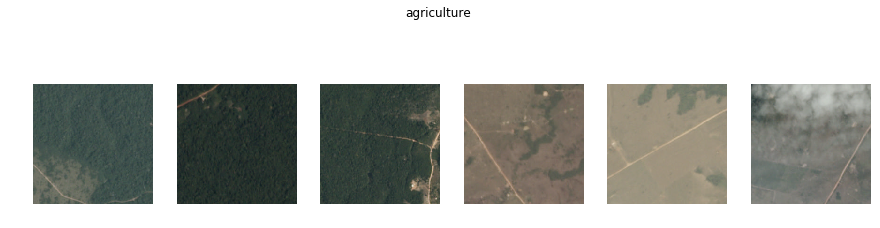

Image: artisinal_mine clear primary road
Neighbor: artisinal_mine clear primary water
Neighbor: agriculture clear cultivation primary
Neighbor: agriculture clear cultivation habitation primary road
Neighbor: agriculture clear primary
Neighbor: artisinal_mine clear primary water


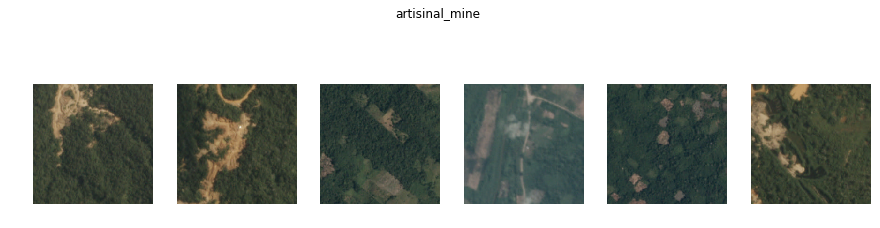

Image: bare_ground clear
Neighbor: bare_ground clear primary
Neighbor: cultivation haze primary water
Neighbor: partly_cloudy primary water
Neighbor: cloudy
Neighbor: agriculture partly_cloudy primary water


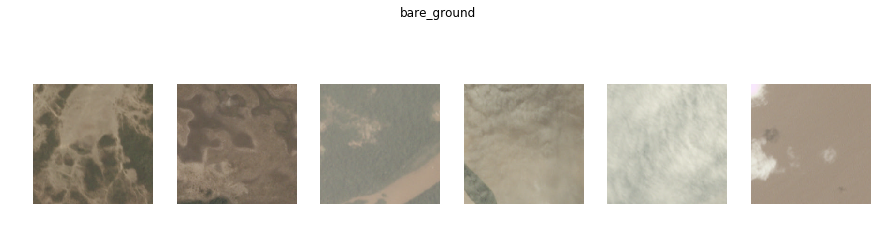

Image: blooming clear primary
Neighbor: clear primary
Neighbor: agriculture clear primary
Neighbor: clear primary
Neighbor: clear primary
Neighbor: clear primary


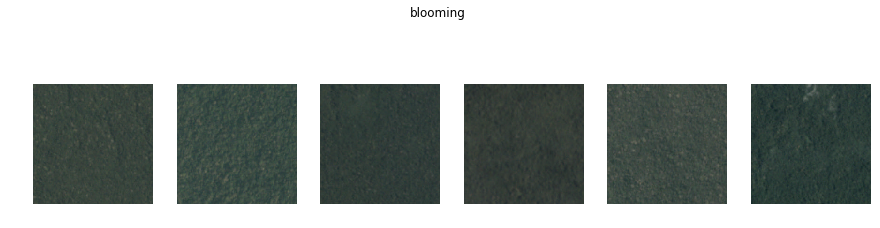

Image: blow_down partly_cloudy primary
Neighbor: partly_cloudy primary road water
Neighbor: partly_cloudy primary
Neighbor: agriculture cultivation partly_cloudy primary
Neighbor: partly_cloudy primary
Neighbor: cultivation partly_cloudy primary slash_burn


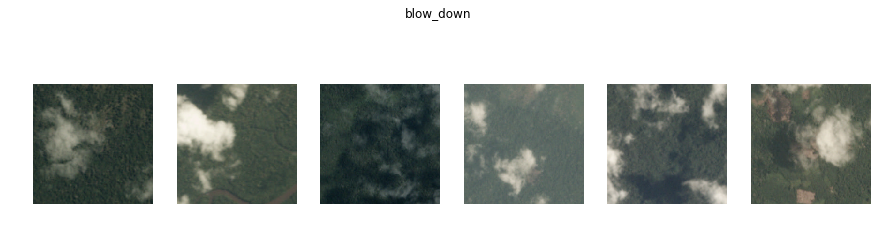

Image: clear primary water
Neighbor: agriculture clear primary
Neighbor: agriculture clear primary
Neighbor: clear primary
Neighbor: partly_cloudy primary
Neighbor: agriculture clear cultivation habitation primary road water


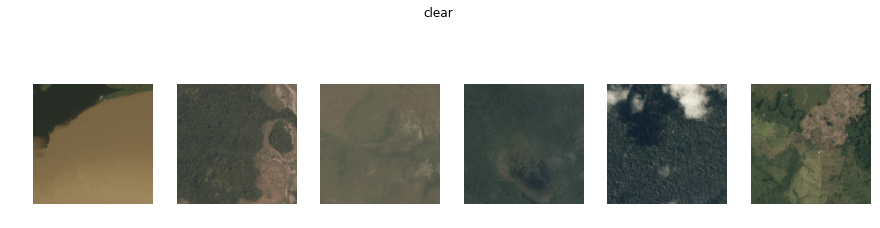

Image: cloudy
Neighbor: cloudy
Neighbor: cloudy
Neighbor: cloudy
Neighbor: cloudy
Neighbor: cloudy


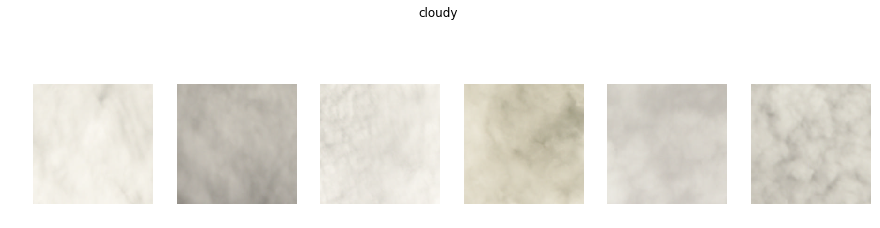

Image: clear conventional_mine habitation primary
Neighbor: agriculture clear cultivation primary
Neighbor: agriculture partly_cloudy primary road
Neighbor: agriculture clear primary
Neighbor: agriculture clear cultivation primary road selective_logging
Neighbor: artisinal_mine clear primary water


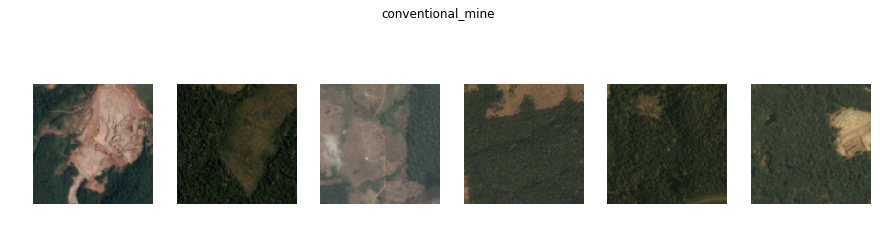

Image: agriculture clear cultivation habitation primary road
Neighbor: agriculture clear primary
Neighbor: agriculture clear primary road slash_burn
Neighbor: agriculture clear primary road
Neighbor: agriculture clear primary
Neighbor: agriculture clear cultivation primary road water


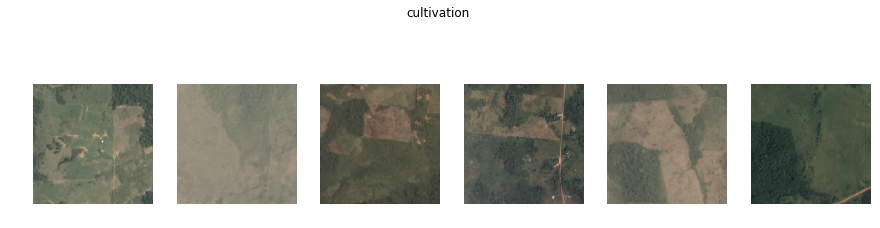

Image: habitation partly_cloudy primary road water
Neighbor: agriculture clear primary
Neighbor: agriculture clear cultivation habitation primary slash_burn
Neighbor: agriculture clear cultivation primary road
Neighbor: partly_cloudy primary water
Neighbor: agriculture clear cultivation primary water


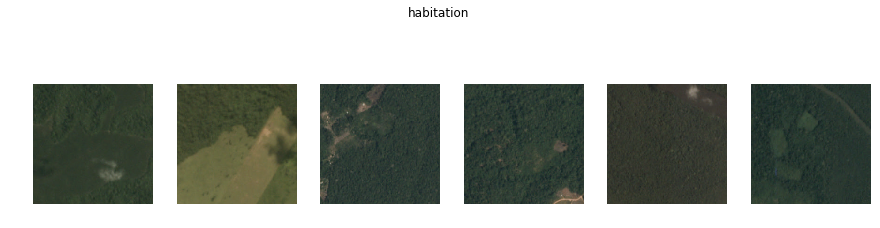

Image: agriculture haze primary road
Neighbor: agriculture partly_cloudy primary
Neighbor: agriculture clear habitation primary road
Neighbor: agriculture clear primary road
Neighbor: agriculture clear cultivation habitation primary road
Neighbor: agriculture habitation partly_cloudy primary road water


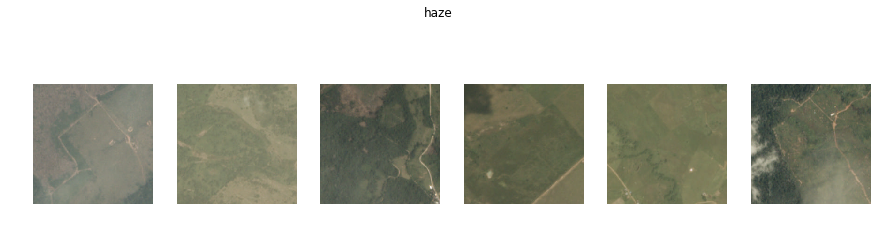

Image: partly_cloudy primary
Neighbor: clear primary
Neighbor: partly_cloudy primary
Neighbor: clear primary
Neighbor: clear primary
Neighbor: clear primary


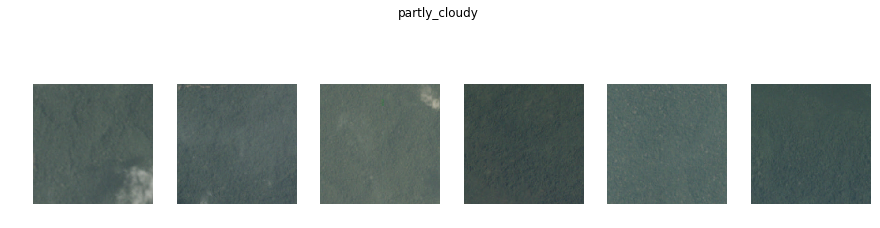

Image: partly_cloudy primary water
Neighbor: agriculture partly_cloudy primary
Neighbor: agriculture clear cultivation primary
Neighbor: agriculture clear cultivation primary
Neighbor: agriculture partly_cloudy primary water
Neighbor: clear cultivation primary water


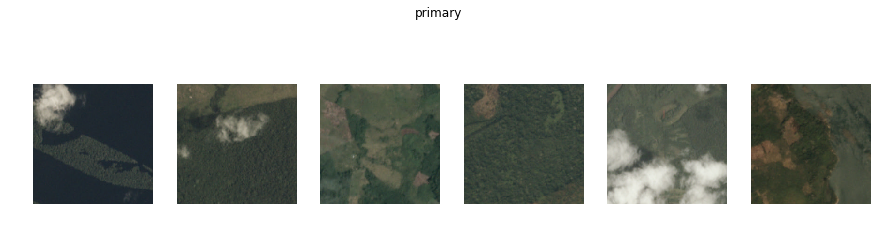

Image: agriculture clear primary road
Neighbor: agriculture clear primary road
Neighbor: agriculture clear primary
Neighbor: agriculture clear primary road
Neighbor: agriculture clear primary
Neighbor: agriculture partly_cloudy primary


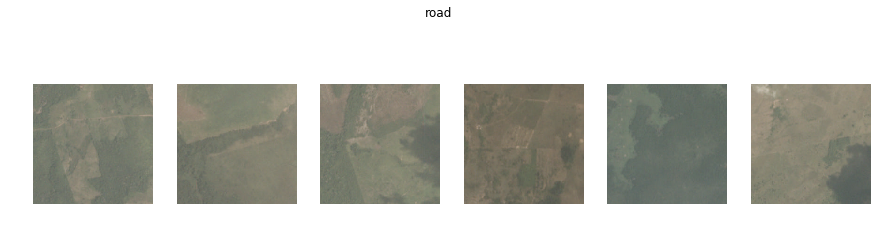

Image: agriculture clear cultivation primary selective_logging
Neighbor: clear cultivation primary
Neighbor: partly_cloudy primary
Neighbor: artisinal_mine clear primary water
Neighbor: clear cultivation primary
Neighbor: partly_cloudy primary


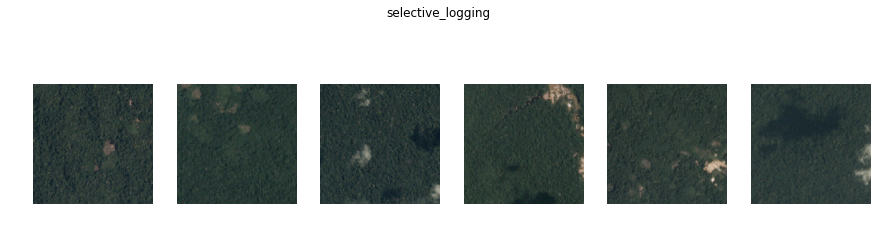

Image: agriculture cultivation partly_cloudy primary slash_burn
Neighbor: partly_cloudy primary
Neighbor: agriculture cultivation partly_cloudy primary
Neighbor: partly_cloudy primary water
Neighbor: partly_cloudy primary
Neighbor: partly_cloudy primary


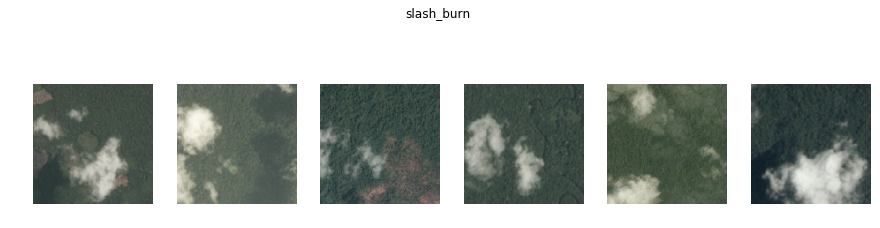

Image: partly_cloudy primary water
Neighbor: partly_cloudy primary
Neighbor: partly_cloudy primary
Neighbor: agriculture partly_cloudy primary
Neighbor: agriculture partly_cloudy primary
Neighbor: partly_cloudy primary


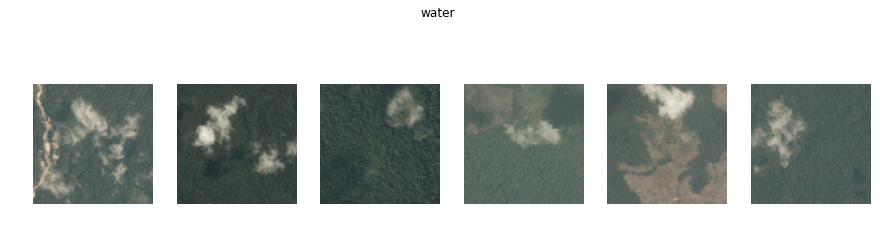

In [33]:
# Pick a random image from each class and retrieve its K nearest neighbors.
for tidx in range(17):
    idx = rng.choice(np.where(tags[:,tidx] == 1)[0])
    print('Image:', binary_to_tagstr(tags[idx]))
    nbridxs = knn.kneighbors(features[np.newaxis,idx], return_distance=False)[0, 1:]
    fig, _ = plt.subplots(1, 6, figsize=(15,4))
    fig.axes[0].imshow(imgs.get(str(idx)))
    fig.axes[0].axis('off')
    for nidx, ax in zip(nbridxs, fig.axes[1:]):
        ax.imshow(imgs.get(str(nidx)))
        ax.axis('off')
        print('Neighbor:', binary_to_tagstr(tags[nidx]))
    plt.suptitle(TAGS[tidx])
    plt.show()